In [151]:
#####時空間テンソル分解#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import gc
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [152]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    if pattern==1:
        z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id

In [153]:
####データの発生####
##データと日付の設定
#データの設定
k1 = 10
k2 = 7
s = 2
m = 3
hh = 5000
location = 3000
target = 20
day = 3
week = 7
month = 31 
year = 12
month_days = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
year_days = np.sum(month_days)
Lambda = np.random.gamma(30, 1/0.2, hh)
pt = np.random.poisson(Lambda, hh)
hhpt = np.sum(pt)

#日付IDを設定
hour_id0 = np.tile(np.arange(day), year_days*m)
day_id0 = np.repeat(np.tile(np.arange(week), int((year_days*m)/week) + 1)[:m*year_days], day)
month_id0 = np.repeat(np.tile(np.repeat(np.arange(year), month_days), m), day)
year_id0 = np.repeat(np.arange(m), year_days*day)
date_id0 = np.array([hour_id0, day_id0, month_id0, year_id0]).T
date_n = np.array([day, week, year])
date = date_id0.shape[0]

In [154]:
##IDとインデックスの設定
#IDの設定
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int") 

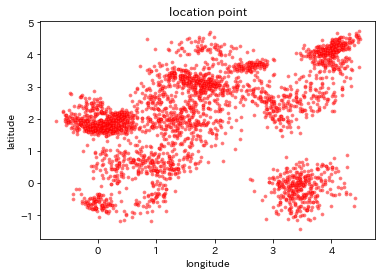

In [155]:
##locationの経緯度とk近傍の生成
#locationの場所集合を生成
topic = 30
rate = np.random.dirichlet(np.repeat(2.0, topic), 1).reshape(-1)
point = np.dot(np.random.multinomial(1, rate, location), range(topic))

#経緯度を生成
longitude = np.array((0, 5)); latitude = np.array((0, 5))
geo_location0 = np.zeros((location, 2))
for j in range(topic):
    index = np.array(range(location))[point==j]
    mu = np.append(np.random.uniform(longitude[0], longitude[1], 1), np.random.uniform(latitude[0], latitude[1], 1))
    cov = np.diag(np.random.uniform(0.01, 0.15, 2))
    value = np.random.uniform(-0.7, 0.7, 1) * np.prod(np.sqrt(np.diag(cov)))
    cov[0, 1] = value; cov[1, 0] = value
    geo_location0[index, :] = np.random.multivariate_normal(mu, cov, index.shape[0])

geo_location = np.min(geo_location0) + geo_location0
plt.scatter(geo_location[:, 0], geo_location[:, 1], s=3, c="pink", alpha=0.5, linewidths="2",
            edgecolors="red")
plt.title("location point")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

#k近傍のlocationを取得
epsilon = 0.5
pattern = np.array([[True, True], [True, False], [False, False], [False, True]])
way_n = pattern.shape[0] 
neighbor_id = np.zeros((location, target), dtype="int") 
neighbor_dist = np.zeros((location, target))
neighbor_way = np.zeros((location, target), dtype="int")

for i in range(location):
    index1 = np.delete(np.arange(location), i)
    distance = np.exp(-np.sqrt(np.sum(np.power(geo_location[i, ] - geo_location[index1, ], 2), axis=1)) / epsilon) 
    sortlist = np.argsort(distance)[::-1]
    neighbor_id[i, ] = index1[sortlist[:target]]
    neighbor_dist[i, ] = distance[sortlist[:target]]
    ways = geo_location[i, ] - geo_location[index1[sortlist[:target]], ]
    for j in range(pattern.shape[0]):
        index2 = np.where(np.sum(np.array((ways > 0)==pattern[j, ], dtype="int"), axis=1)==2)[0]
        neighbor_way[i, index2] = j
    
#方角のインデックス
ways_list = [j for j in range(target)]
for i in range(target):
    temp_list = [i for i in range(way_n)]
    for j in range(way_n):
        temp_list[j] = np.array(np.where(neighbor_way[:, i]==j)[0], dtype="int")
    ways_list[i] = temp_list

In [156]:
 ##locationの割当を生成
#セグメント割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.5, location), topic)
theta = np.random.dirichlet(np.repeat(1.0, topic), hh)

#多項分布からアイテムを生成
z = np.repeat(0, hhpt)
location_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    z[d_list[i]] = np.dot(np.random.multinomial(1, theta[i, ], pt[i]), np.arange(topic))
    location_id[d_list[i]] = np.array(rmnom(phi[z[d_list[i]], ], pt[i], location, np.arange(pt[i]), 0), dtype="int")

#インデックスを取得
location_list = [i for i in range(location)]
location_n = np.repeat(0, location)
for i in range(location):
    location_list[i] = np.array(np.where(location_id==i)[0], dtype="int")
    location_n[i] = location_list[i].shape[0]  

0
1000
2000
3000
4000


In [157]:
##時間割当の生成
#パラメータを生成
phi_hour = np.random.dirichlet(np.repeat(1.0, day), topic)
phi_day = np.random.dirichlet(np.repeat(1.0, week), topic)
phi_month = np.random.dirichlet(np.repeat(1.0, year), topic)
phi_year = np.random.dirichlet(np.repeat(1.0, m), topic)

#多項分布から時間割当を生成
date_id = np.repeat(np.nan, hhpt)
hour_id = np.array(rmnom(phi_hour[z, ], hhpt, day, np.arange(hhpt), 0), dtype="int")
day_id = np.array(rmnom(phi_day[z, ], hhpt, week, np.arange(hhpt), 0), dtype="int")
month_id = np.array(rmnom(phi_month[z, ], hhpt, year, np.arange(hhpt), 0), dtype="int")
year_id = np.array(rmnom(phi_year[z, ], hhpt, m, np.arange(hhpt), 0), dtype="int")
for i in range(hhpt):
    if i%100000==0:
        print(i)
    index = np.where(((hour_id0==hour_id[i]) & (day_id0==day_id[i]) & (month_id0==month_id[i]) & (year_id0==year_id[i])))[0]
    date_id[i] = index[np.argmax(np.random.multinomial(1, np.repeat(1/index.shape[0], index.shape[0]), 1))]
date_id = np.array(date_id, dtype="int")

#インデックスを取得
date_list = [i for i in range(date)]
date_n = np.repeat(0, date)
for i in range(date):
    date_list[i] = np.array(np.where(date_id==i)[0], dtype="int")
    date_n[i] = date_list[i].shape[0]  

0
100000
200000
300000
400000
500000
600000
700000


In [170]:
####応答変数を生成####
per_min = 150; per_max = 150
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##パラメータの生成
    #階層モデルの事前分布の生成
    alpha_u = np.repeat(0.0, k1)
    alpha_v = np.zeros((k1, k1, way_n))
    for j in range(way_n):
        alpha_v[:, :, j] = np.random.normal(0, 0.2, k1*k1).reshape(k1, k1)
    alpha_h = np.random.multivariate_normal(np.repeat(0.0, k2), np.diag(np.repeat(0.5, k2)), day) 
    alpha_d = np.random.multivariate_normal(np.repeat(0.0, k2), np.diag(np.repeat(0.5, k2)), week) 
    alpha_m = np.random.multivariate_normal(np.repeat(0.0, k2), np.diag(np.repeat(0.5, k2)), year) 
    omega = np.random.normal(0, 0.5, k1*k2).reshape(k2, k1)
    tau_u = np.array([0.6])
    tau_v = np.array([0.7])
    Cov_u = np.diag(np.repeat(0.75, k1))
    Cov_v = np.diag(np.repeat(0.25, k1))
    Cov_d = np.diag(np.repeat(0.25, k1))
    alphat_u = alpha_u.copy(); alphat_v = alpha_v.copy()
    alphat_h = alpha_h.copy(); alphat_d = alpha_d.copy(); alphat_m = alpha_m.copy(); omegat = omega.copy()
    taut_u = tau_u.copy(); taut_v = tau_v.copy(); Covt_u = Cov_u.copy(); Covt_v = Cov_v.copy(); Covt_d = Cov_d.copy()

    #モデルパラメータの生成
    Sigma = np.array([1.0])
    beta = np.array([-0.7])
    beta_u = np.random.normal(0, tau_u, hh)
    beta_v = np.random.normal(0, tau_v, location)
    theta_u = np.random.multivariate_normal(alpha_u, Cov_u, hh)
    betat = beta.copy(); betat_u = beta_u.copy(); betat_v = beta_v.copy(); thetat_u = theta_u.copy()
    
    #locationの特徴行列を生成
    theta_v0 = np.random.multivariate_normal(np.repeat(0.0, k1), np.diag(np.repeat(0.25, k1)), location)
    theta_v1 = np.zeros((location, k1))
    for i in range(target):
        for j in range(way_n):
            index = ways_list[i][j]
            theta_v1[index, ] += np.dot(theta_v0[neighbor_id[index, i], ] * neighbor_dist[index, i][:, np.newaxis], alpha_v[:, :, j])
    theta_v = theta_v1 + np.random.multivariate_normal(np.repeat(0, k1), Cov_v, location)
    thetat_v = theta_v.copy()
    
    #時間の特徴行列を生成
    mu_date = np.dot(alpha_h[hour_id0, ] * alpha_d[day_id0, ] * alpha_m[month_id0, ], omega)
    theta_d = mu_date + np.random.multivariate_normal(np.repeat(0.0, k1), Cov_d, date)
    thetat_d = theta_d.copy()
    
    ##正規分布から応答変数を生成
    #テンソル分解の期待値
    beta_mu = beta + beta_u[d_id] + beta_v[location_id]
    uv = np.sum(theta_u[d_id, ] * theta_v[location_id, ] * theta_d[date_id, ], axis=1)
    mu = beta_mu + uv

    #潜在効用から二値変数を生成
    U = np.random.normal(mu, Sigma, hhpt)
    y = (U >= 0)*1 + (U < 0)*0
    Prob = norm.cdf(mu, 0, Sigma)

    #break条件
    if ((np.mean(y) > 0.2) & (np.mean(y) < 0.4) & (np.sum(U <= -7.5) < hhpt/per_min) & (np.sum(U > 7.5) < hhpt/per_max)):
        break

1
2
3
4
5
6
7
8
9
10
11


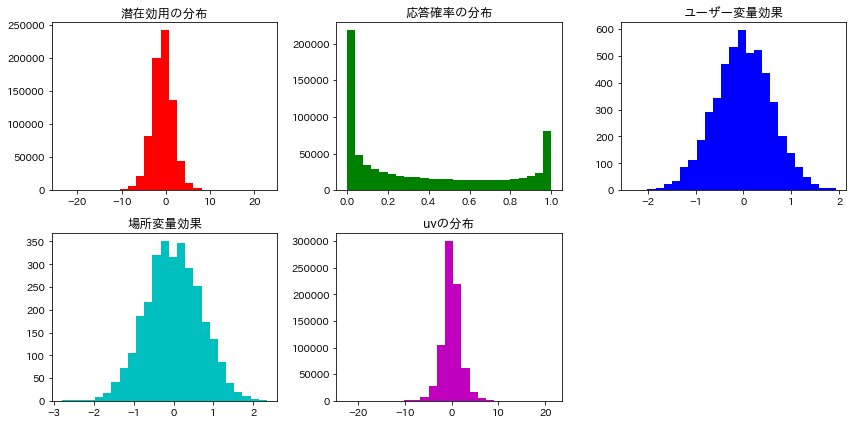

In [171]:
#潜在変数ごとのヒストグラム
dt = [U, Prob, beta_u, beta_v, uv]
fig_range = np.append(np.array([np.min(U), 0, np.min(beta_u), np.min(beta_v), np.min(uv)]), 
                      np.array([np.max(U), 1.0, np.max(beta_u), np.max(beta_v), np.max(uv)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["潜在効用の分布", "応答確率の分布", "ユーザー変量効果", "場所変量効果", "uvの分布"]
fig = plt.figure(figsize=(12.0, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [172]:
####マルコフ連鎖モンテカルロ法でパラメータを推定####
##切断正規分布の乱数を発生させる関数
def rtnorm(mu, sigma, a, b, n):
    FA = norm.cdf(a, mu, sigma)
    FB = norm.cdf(b, mu, sigma)
    return norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma)

In [173]:
##ベイジアン多変量回帰モデルをギブスサンプリングする関数
def rmultireg(Y, X, inv_XXV, XY, Cov, ADelta, Deltabar, V, nu, n, col, k):
    #事後分布のパラメータを設定
    beta_mu = np.dot(inv_XXV, XY + np.dot(ADelta, Deltabar)).T.reshape(-1)   #平均ベクトル
    sigma = np.kron(Cov, inv_XXV)   #分散共分散行列

    #パラメータをサンプリング
    beta_vec = np.random.multivariate_normal(beta_mu, sigma, 1)
    beta = beta_vec.reshape(col, k, order='F')   #回帰行列に変換

    
    ##逆ウィシャート分布から分散共分散行列をサンプリング
    #モデル誤差を設定
    mu = np.dot(X, beta)
    er = Y - mu

    #逆ウィシャート分布のパラメータ
    IW_R = np.dot(er.T, er) + V
    Sn = n + nu

    #パラメータをサンプリング
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)
    return beta, Cov

In [174]:
##アルゴリズムの設定
k = 10
R = 2000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10
target_iter = 50

In [175]:
##データの設定
#切断領域を定義
rho = 10.0
a = (1-y)*(-rho) + y*0
b = y*rho + (1-y)*0

In [176]:
##事前分布の設定
#階層モデルの事前分布の設定
Deltabar1 = np.zeros((k1, k1))
Deltabar2 = np.zeros((k2, k1))
ADelta1 = 10 * np.diag(np.ones(k1))
ADelta2 = 10 * np.diag(np.ones(k2))
nu1 = 1.0
nu2 = 1.0
V1 = 0.1 * np.diag(np.ones(k1))
V2 = 0.1 * np.diag(np.ones(k2))

#モデルパラメータの事前分布
s0 = 1.0
v0 = 1.0

In [177]:
##パラメータの真値
#階層モデルのパラメータの真値
alpha_u = alphat_u.copy()
alpha_v = alphat_v.copy()
alpha_h = alphat_h.copy()
alpha_d = alphat_d.copy()
alpha_m = alphat_m.copy()
omega = omegat.copy()
tau_u = taut_u.copy()
tau_v = taut_v.copy()
Cov_u = Covt_u.copy()
Cov_v = Covt_v.copy()
Cov_d = Covt_d.copy()

#モデルパラメータの真値
Sigma = np.array([1.0])
beta = betat.copy()
beta_u = betat_u.copy()
beta_v = betat_v.copy()
theta_u = thetat_u.copy()
theta_v = thetat_v.copy()
theta_d = thetat_d.copy()

#テンソル分解の期待値
beta_mu = beta + beta_u[d_id] + beta_v[location_id]
uv = np.sum(theta_u[d_id, ] * theta_v[location_id, ] * theta_d[date_id, ], axis=1)
mu = beta_mu + uv

In [183]:
##パラメータの格納用配列
#階層モデルのパラメータの格納用配列
ALPHA_V = np.zeros((k1, k1, way_n, int(R/keep)))
ALPHA_H = np.zeros((day, k2, int(R/keep)))
ALPHA_D = np.zeros((week, k2, way_n, int(R/keep)))
ALPHA_M = np.zeros((year, k2, way_n, int(R/keep)))
OMEGA = np.zeros((k2, k1, int(R/keep)))
ALPHA_V = np.zeros((k1, k1, way_n, int(R/keep)))
TAU_U = np.zeros((int(R/keep), hh))
TAU_V = np.zeros((int(R/keep), location))
COV_U = np.zeros((k1, k1, int(R/keep)))
COV_V = np.zeros((k1, k1, int(R/keep)))
COV_D = np.zeros((k1, k1, int(R/keep)))

#モデルパラメータの格納用配列
BETA = np.repeat(0.0, int(R/keep))
BETA_U = np.zeros((int(R/keep), hh))
BETA_V = np.zeros((int(R/keep), location))
THETA_U = np.zeros((hh, k1, int(R/keep)))
THETA_V = np.zeros((location, k1, int(R/keep)))
THETA_D = np.zeros((date, k1, int(R/keep)))

In [ ]:
####ギブスサンプリングでパラメータをサンプリング####

